In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Split the data into training and testing sets
X_train, X_test = mnist.data[:60000], mnist.data[60000:]
y_train, y_test = mnist.target[:60000], mnist.target[60000:]

# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [2]:
X_train = torch.tensor(X_train.values)
X_test = torch.tensor(X_test.values)


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def decoder_only(self,x):
        x = self.decoder(x)
        return x



model = Autoencoder().to("cuda")
print(model)
X_train = X_train.to("cuda")


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [4]:
import tqdm

optim = torch.optim.Adam(model.parameters(),lr=3e-4)
loss_fn = nn.MSELoss()

# Train the model
epochs = 100
batch_size = 512
num_batches = len(X_train) // batch_size

with tqdm.tqdm(total=epochs * num_batches, desc="Training") as pbar:
    for epoch in range(epochs):
        model.train()
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = (batch_idx + 1) * batch_size
            inputs = X_train[start_idx:end_idx]
            
            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, inputs)
            loss.backward()
            optim.step()
            
            pbar.update(1)
            pbar.set_postfix({"Epoch": epoch+1, "Batch": batch_idx+1, "Loss": f"{loss.item():.4f}"})

Training: 100%|██████████| 11700/11700 [00:23<00:00, 494.95it/s, Epoch=100, Batch=117, Loss=0.0199]


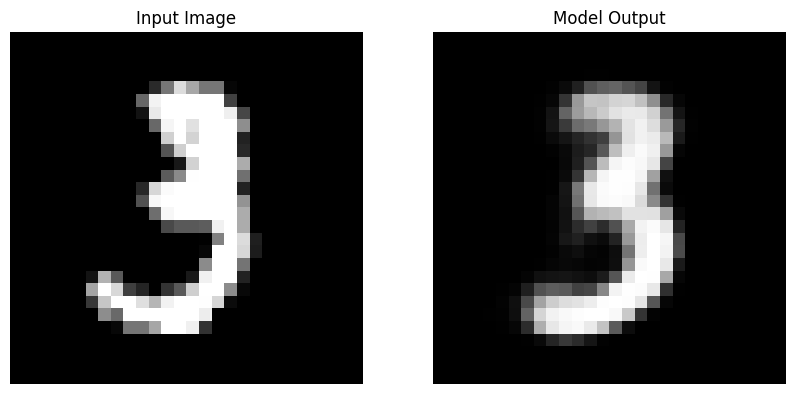

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Select one item from X_train
item = X_train[10]

# Run forward pass
output = model(item.unsqueeze(0))  # Add batch dimension
output = output.squeeze(0)  # Remove batch dimension

# Move data back to CPU for plotting
item = item.cpu().numpy()
output = output.cpu().detach().numpy()

# Reshape data to 28x28 images
image = item.reshape((28, 28))
output_image = output.reshape((28, 28))

# Plot input and output images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Input Image')

axs[1].imshow(output_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Model Output')

plt.show()

In [ ]:
item = torch.randn(12).to("cuda")

# Run forward pass
output = model.decoder_only(item.unsqueeze(0))  # Add batch dimension
output = output.squeeze(0)  # Remove batch dimension

# Move data back to CPU for plotting
item = item.cpu().numpy()
output = output.cpu().detach().numpy()

# Reshape data to 28x28 images
image = item.reshape((28, 28))
output_image = output.reshape((28, 28))

# Plot input and output images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Input Image')

axs[1].imshow(output_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Model Output')

plt.show()